In [1]:
import numpy as np
import scipy as sp
import scipy.optimize
import scipy.integrate
import scipy.special
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from matplotlib.colors import LogNorm
import matplotlib
from findiff import FinDiff
from scipy.signal import savgol_filter

plt.rcParams['animation.html'] = 'html5'
rc('font',**{'family':'serif'})
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amsmath}')

from elastic_body import *
from utils import *

import os
import sys

FIGURES_PATH = os.path.join(pathlib.Path(PROJ_PATH).parent.resolve(), 'figures')

## Load 3D results

In [21]:
pref = 'rod_model_material2_weak_nonlin_visc_long_reduced600_'
path_prefix = os.path.join(PROJ_PATH, RESULTS_DIR, pref)
# load params
f = open(path_prefix + PARAMS_FILENAME, 'r')
params_dict = parse_input_file(f)
f.close()
body, mesh = create_body_and_mesh(params_dict)
t0, dt, tmax = params_dict[START_TIME], params_dict[TIME_STEP], params_dict[STOP_TIME]
T = np.arange(t0, tmax + dt, dt)
# load func
U_func = np.load(path_prefix + U_FILENAME + '.npy')
U = TensorField(mesh, U_func)

In [22]:
# consider results for T >= 5.4 ms
i0 = np.where(T==5400)[0][0]
t0 = T[i0]
print(i0, t0)
T = T[i0:] - t0
U = U[i0:]

9 5400.0


In [23]:
# find the soliton amplitude and position at t0
x = np.linspace(0, body.L, num=4001)
m = x[np.argmax(-U[0,0].diff()(x + body.c0*t0,0,0))]
A0 = (-U[0].diff()(x,0,0)).max()
print(m)

96.0


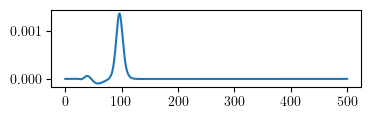

In [24]:
# strain profile at t0
plt.figure(figsize=(4,1))
plt.plot(x, -U[0,0].diff()(x + body.c0*t0,0,0))

In [25]:
# width parameter at t0
L0 = body.soliton_kdv_width(-A0)
print(A0, L0)

0.001367443927486663 7.705355961150567


## Decaying soliton

In [26]:
integr = sp.integrate.ode(der_lin)
integr.set_integrator('dop853', rtol=1e-10, atol=1e-10, nsteps=1e6)
integr.set_f_params(body)
integr.set_initial_value(np.array([L0, m]), t=0)
sol_lin_decay = np.array([integr.integrate(t) for t in T])

/home/fgarbuzov/miniconda3/envs/spectral/lib/python3.11/site-packages/scipy/integrate/_ode.py:1179: UserWarning: dop853: step size becomes too small
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


In [27]:
L_lin, x0_lin = sol_lin_decay.T
A_lin = body.soliton_kdv_ampl(L_lin)

In [28]:
integr = sp.integrate.ode(der_nl)
integr.set_integrator('dop853', rtol=1e-10, atol=1e-10, nsteps=1e6)
integr.set_f_params(body)
integr.set_initial_value(np.array([L0, m]), t=0)

In [38]:
# takes some time
sol_nl_decay = np.array([integr.integrate(t) for t in T])
L, x0 = sol_nl_decay.T
A = body.soliton_kdv_ampl(L)
np.save(os.path.join(PROJ_PATH, RESULTS_DIR, pref + 'L_x0_nonlin_ref.npy'), sol_nl_decay.T)

In [31]:
L, x0 = np.load(os.path.join(PROJ_PATH, RESULTS_DIR, pref + 'L_x0_nonlin_ref.npy'))
A = body.soliton_kdv_ampl(L)

## Comparison with 3D simulation

96.0


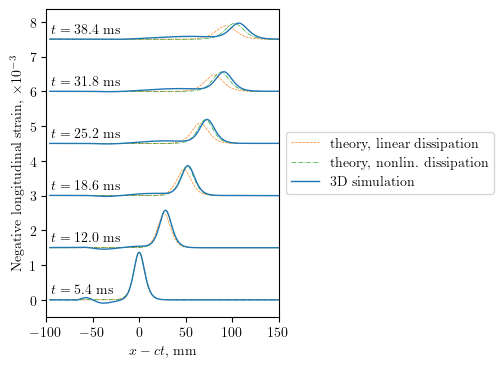

In [32]:
fig, ax = plt.subplots(figsize=(3,4))
col = ['C0', 'C1', 'C2', 'C3']
x_sc = 1#body.R
t_sc = 1#body.R/body.c0
n = 6
shift = 1.5
u_scale = 1e-3
print(m)
T_loc = T[T<40000-t0+dt]
nt = len(T_loc)
for j, t_i in enumerate(range(0, nt, (nt - 1)//(n-1))):
    u_sol_lin = -body.soliton_kdv(A_lin[t_i], x - (x0_lin[t_i] - body.c0*T[t_i]), 0)[0]
    u_sol = -body.soliton_kdv(A[t_i], x - (x0[t_i] - body.c0*T[t_i]), 0)[0]
    ax.plot((x - m)/x_sc, j*shift + u_sol_lin/u_scale, '--', lw=0.5, c='C1')
    ax.plot((x - m)/x_sc, j*shift + u_sol/u_scale, '-.', lw=0.5, c='C2')
    u = -U[t_i, 0].diff()
    ax.plot((x - m)/x_sc, j*shift + u(x + body.c0*(T[t_i]+t0), 0, 0)/u_scale, lw=1, c='C0')
    ax.text(x[10]-m, j*shift+0.3*shift/2.5, "$t = %.1f$ ms" % (round((t0 + T[t_i]))/1000))
ax.margins(x=0)
ax.set_xlim(-100, 150)
ax.set_xlabel('$x - ct,$ mm')
ax.set_ylabel('Negative longitudinal strain, $\\times 10^{-3}$')
ax.legend(['theory, linear dissipation', 
           'theory, nonlin. dissipation',
           '3D simulation'], loc='center left', bbox_to_anchor=(1, 0.5))